Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from fbprophet import Prophet

def week_year_to_date(year, week):
    starting_date = datetime(int(year), 1, 1)
    return starting_date + timedelta(int(week)*7-7)


ModuleNotFoundError: No module named 'fbprophet'

In [19]:
df = pd.read_csv('train.csv')
df.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

Adding Features

In [20]:
## Dropping ID ##

df = df.drop(columns = ['ID_LAT_LON_YEAR_WEEK'])

## Regular Features ##

df['all_densities'] = (df.SulphurDioxide_SO2_column_number_density/np.mean(df.SulphurDioxide_SO2_column_number_density)
                    + df.CarbonMonoxide_CO_column_number_density/np.mean(df.CarbonMonoxide_CO_column_number_density)
                    + df.NitrogenDioxide_NO2_column_number_density/np.mean(df.NitrogenDioxide_NO2_column_number_density)
                    + df.Ozone_O3_column_number_density/np.mean(df.Ozone_O3_column_number_density)
                    + df.Formaldehyde_tropospheric_HCHO_column_number_density)/np.mean(df.Formaldehyde_tropospheric_HCHO_column_number_density)

## Features for groups AND Filling nans ##

df_grouped = df.groupby(['longitude', 'latitude'])
lst = []
for name, group_df in df_grouped:
    group_df['rolling_SulphurDioxide_SO2_column_number_density'] = group_df['SulphurDioxide_SO2_column_number_density'].rolling(window = 9, center = True).mean()
    group_df = group_df.interpolate(method='linear', limit_direction='both')
    lst.append(group_df)

df = pd.concat(lst)

## Features for Historical Values ##

last_year_df = (df
                .assign(year=df['year'] + 1)
                .loc[:, ['emission', 'year', 'week_no', 'longitude', 'latitude']]
                .rename(columns={'emission': 'last_year_emission'}))
df = pd.merge(df, last_year_df, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')

## Non numeric features ##
df['date'] =  df.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)
df['long_lat'] = df.apply(lambda row : str(row.longitude) + str(row.latitude), axis = 1)


Exploratory Data Analysis

In [ ]:
df_ex = (df
         .query("latitude == -3.161")
         .query("longitude == 28.839"))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_2 = (df_ex
        .corr()
        .loc[:, 'emission']
        .sort_values())
print(df_2)

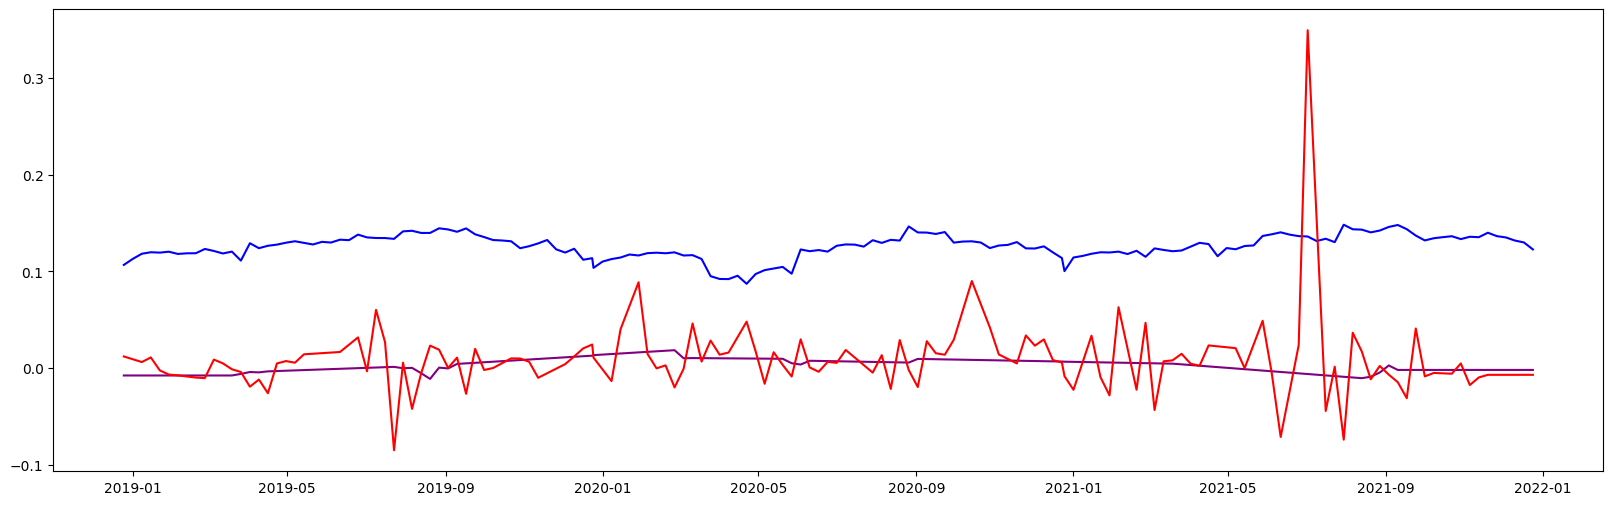

In [24]:
df_ex = (df
         .query("latitude == -3.161")
         .query("longitude == 28.839"))
plt.figure(figsize = [20, 6])
plt.plot(df_ex.date, df_ex.emission, color = 'blue')
plt.plot(df_ex.date, df_ex.rolling_SulphurDioxide_SO2_column_number_density*100, color = 'purple')
plt.plot(df_ex.date, df_ex.SulphurDioxide_SO2_column_number_density*100, color = 'red')
plt.show()

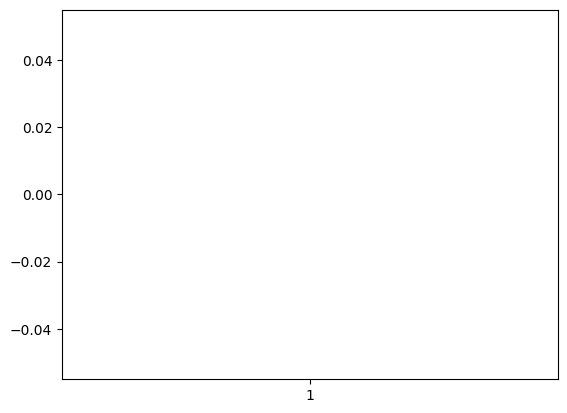

In [32]:
plt.figure()
df_b = df['SulphurDioxide_SO2_column_number_density_15km']
plt.boxplot(df_b)
plt.show()

Selecting Features

In [30]:
df = (df
      .loc[:, ['year'
               , 'week_no'
               , 'last_year_emission'
               , 'emission'
               , 'SulphurDioxide_SO2_column_number_density'
               , 'CarbonMonoxide_CO_column_number_density'
               , 'NitrogenDioxide_NO2_column_number_density'
               , 'Ozone_O3_column_number_density'
               , 'Formaldehyde_tropospheric_HCHO_column_number_density'
               , 'Cloud_cloud_fraction'
               , 'UvAerosolIndex_absorbing_aerosol_index'
               , 'Cloud_cloud_optical_depth']]
      .query("year != 2019")
 ##     .query("longitude == 30.389")
 ##     .query("latitude == -1.211")
      )

Run Model

Mean Squared Error: 1028.455995399374
SD Error:  14.778247418528089


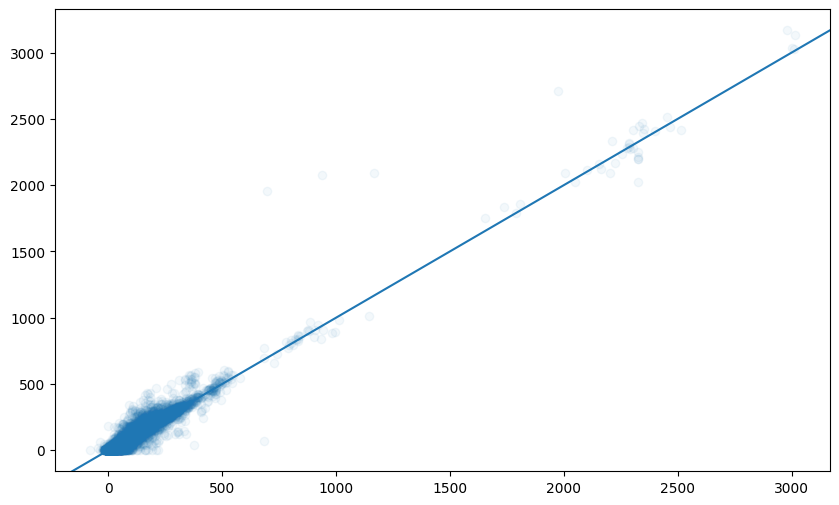

[0.03897731 0.01353554 0.00565705 0.03849658 0.02535656 0.01877455
 0.05240006 0.06069063 0.09178485 0.10379495 0.5505319 ]


In [57]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['emission']), df.emission, test_size = .2)
model = XGBRegressor()
selector = SelectFromModel(model)
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)
model.fit(x_train_selected, y_train)
y_pred = model.predict(x_test_selected)
mse = mean_squared_error(y_test, y_pred)
se = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', se)
plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test, alpha = .01)
plt.axline((0, 0), slope=1)
plt.show()
print(model.feature_importances_)


In [56]:
selector.get_feature_names_out()

array(['year', 'CarbonMonoxide_CO_column_number_density',
       'UvAerosolIndex_sensor_altitude',
       'UvAerosolLayerHeight_aerosol_height',
       'UvAerosolLayerHeight_aerosol_pressure',
       'UvAerosolLayerHeight_aerosol_optical_depth',
       'UvAerosolLayerHeight_sensor_zenith_angle',
       'UvAerosolLayerHeight_sensor_azimuth_angle',
       'UvAerosolLayerHeight_solar_azimuth_angle',
       'UvAerosolLayerHeight_solar_zenith_angle', 'last_year_emission'],
      dtype='<U56')

Mean Squared Error: 174.36281682211754
SD Error:  5.97526897523622


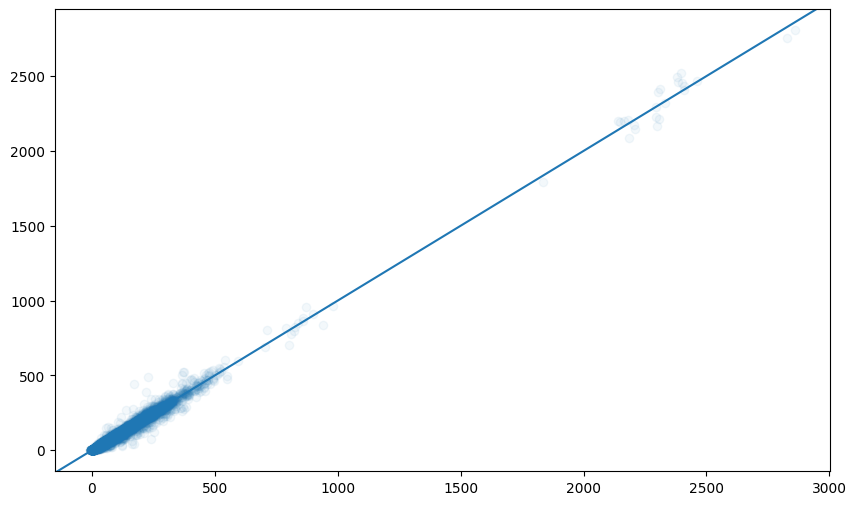

[0.0374164  0.01740979 0.938787   0.00404515 0.00234171]


In [40]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['emission']), df.emission, test_size = .2)
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
se = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', se)
plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test, alpha = .05)
plt.axline((0, 0), slope=1)
plt.show()
print(model.feature_importances_)


In [ ]:
x_test['date'] = x_test.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)
x_test = x_test.sort_values(by='date')
plt.figure(figsize = [10, 6])
plt.plot(x_test.date, y_test, color = 'blue')
plt.plot(x_test.date, y_pred, color = 'red')
plt.plot(x_test.date, x_test.SulphurDioxide_SO2_column_number_density_amf*100)
plt.show()

Separate models for each location

In [299]:
pairs = df.loc[:,['longitude', 'latitude']].drop_duplicates()

for row in pairs.iterrows():
    df_new = df[df['longitude'] == row[1]['longitude']]
    df_new = df_new[df_new['latitude'] == row[1]['latitude']]
    x_train, x_test, y_train, y_test = train_test_split(df_new.drop(columns = ['emission']), df_new.emission, test_size = .2)
    model = XGBRegressor()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse, ' Longitude: ', row[1]['longitude'], ' Latitude: ', row[1]['latitude'])

Mean Squared Error: 0.1960378322368034  Longitude:  29.29  Latitude:  -0.51
Mean Squared Error: 0.07961149705240513  Longitude:  29.472  Latitude:  -0.528
Mean Squared Error: 0.0010454746415210403  Longitude:  29.653  Latitude:  -0.547
Mean Squared Error: 50.71225226464414  Longitude:  30.031  Latitude:  -0.569
Mean Squared Error: 4.5718560084813894e-05  Longitude:  29.102  Latitude:  -0.598
Mean Squared Error: 39.35029154539575  Longitude:  29.896  Latitude:  -0.604
Mean Squared Error: 41.932208625136255  Longitude:  30.885  Latitude:  -0.615
Mean Squared Error: 137.15019308088154  Longitude:  29.773  Latitude:  -0.627
Mean Squared Error: 13.979794435863688  Longitude:  30.763  Latitude:  -0.637
Mean Squared Error: 10.19848225562868  Longitude:  30.447  Latitude:  -0.653
Mean Squared Error: 4.280432843070949  Longitude:  30.341  Latitude:  -0.659
Mean Squared Error: 24.632450536005834  Longitude:  30.433  Latitude:  -0.667
Mean Squared Error: 0.0016084124362059013  Longitude:  29.623 

Producing Multiple-Model Test Results

In [307]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

last_year_df_train = (df_train
                .assign(year=df_train['year'] + 1)
                .loc[:, ['emission', 'year', 'week_no', 'longitude', 'latitude']]
                .rename(columns={'emission': 'last_year_emission'}))
df_train = pd.merge(df_train, last_year_df_train, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df_train = (df_train
                    .loc[:, ['longitude'
                            , 'latitude'
                            , 'year'
                            , 'week_no'
                            , 'last_year_emission'
                            , 'emission'
                            , 'SulphurDioxide_SO2_column_number_density'
                            , 'CarbonMonoxide_CO_column_number_density'
                            , 'NitrogenDioxide_NO2_column_number_density'
                            , 'Ozone_O3_column_number_density'
                            , 'Formaldehyde_tropospheric_HCHO_column_number_density'
                            , 'Cloud_cloud_fraction'
                            , 'UvAerosolIndex_absorbing_aerosol_index'
                            , 'Cloud_cloud_optical_depth']]
      .query("year != 2019"))

last_year_df_test = (df_train
                            .assign(year=df_train['year'] + 1)
                            .loc[:, ['emission', 'year', 'week_no', 'longitude', 'latitude']]
                            .rename(columns={'emission': 'last_year_emission'}))
df_test = pd.merge(df_test, last_year_df_test, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df_test = (df_test
                    .loc[:, ['longitude'
                            , 'latitude'
                            , 'year'
                            , 'week_no'
                            , 'last_year_emission'
                            , 'SulphurDioxide_SO2_column_number_density'
                            , 'CarbonMonoxide_CO_column_number_density'
                            , 'NitrogenDioxide_NO2_column_number_density'
                            , 'Ozone_O3_column_number_density'
                            , 'Formaldehyde_tropospheric_HCHO_column_number_density'
                            , 'Cloud_cloud_fraction'
                            , 'UvAerosolIndex_absorbing_aerosol_index'
                            , 'Cloud_cloud_optical_depth']])


pairs = df_train.loc[:,['longitude', 'latitude']].drop_duplicates()

listed_dfs = []

for row in pairs.iterrows():
    df_new = df_train[df_train['longitude'] == row[1]['longitude']]
    df_new = df_new[df_new['latitude'] == row[1]['latitude']]
    df_test_new = df_test[df_test['longitude'] == row[1]['longitude']]
    df_test_new = df_test_new[df_test_new['latitude'] == row[1]['latitude']]
    x_train = df_new.drop(columns = ['emission'])
    y_train = df_new.emission
    x_test = df_test_new
    model = XGBRegressor()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    df_final = pd.DataFrame({
        'longitude': df_test_new['longitude'],
        'latitude': df_test_new['latitude'],
        'year': df_test_new['year'],
        'week_no': df_test_new['week_no'],
        'emission': y_pred
    })
    listed_dfs.append(df_final)

final_result = pd.concat(listed_dfs, ignore_index=True)


In [312]:
id_table = (pd.read_csv('test.csv')
            .loc[:, ['longitude', 'latitude', 'year', 'week_no', 'ID_LAT_LON_YEAR_WEEK']])
export = (pd.merge(final_result, id_table, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
            .loc[:, ['ID_LAT_LON_YEAR_WEEK', 'emission']])
export.to_csv('submission.csv', index=False)


Producing One-Model Test Results

In [349]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

last_year_df_train = (df_train
                .assign(year=df_train['year'] + 1)
                .loc[:, ['emission', 'year', 'week_no', 'longitude', 'latitude']]
                .rename(columns={'emission': 'last_year_emission'}))
df_train = pd.merge(df_train, last_year_df_train, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df_train_1 = (df_train
                    .loc[:, ['year'
                            , 'week_no'
                            , 'last_year_emission'
                            , 'emission'
                            , 'SulphurDioxide_SO2_column_number_density'
                            , 'CarbonMonoxide_CO_column_number_density'
                            , 'NitrogenDioxide_NO2_column_number_density'
                            , 'Ozone_O3_column_number_density'
                            , 'Formaldehyde_tropospheric_HCHO_column_number_density'
                            , 'Cloud_cloud_fraction'
                            , 'UvAerosolIndex_absorbing_aerosol_index'
                            , 'Cloud_cloud_optical_depth']]
      .query("year != 2019"))

last_year_df_test = (df_train
                            .assign(year=df_train['year'] + 1)
                            .loc[:, ['emission', 'year', 'week_no', 'longitude', 'latitude']]
                            .rename(columns={'emission': 'last_year_emission'}))
df_test = pd.merge(df_test, last_year_df_test, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df_test_1 = (df_test
                    .loc[:, [ 'year'
                            , 'week_no'
                            , 'last_year_emission'
                            , 'SulphurDioxide_SO2_column_number_density'
                            , 'CarbonMonoxide_CO_column_number_density'
                            , 'NitrogenDioxide_NO2_column_number_density'
                            , 'Ozone_O3_column_number_density'
                            , 'Formaldehyde_tropospheric_HCHO_column_number_density'
                            , 'Cloud_cloud_fraction'
                            , 'UvAerosolIndex_absorbing_aerosol_index'
                            , 'Cloud_cloud_optical_depth']])

x_train = df_train_1.drop(columns = ['emission'])
y_train = df_train_1.emission
x_test = df_test_1
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
final_result = pd.DataFrame({
    'longitude': df_test['longitude'],
    'latitude': df_test['latitude'],
    'year': df_test['year'],
    'week_no': df_test['week_no'],
    'emission': y_pred
})

In [350]:
id_table = (pd.read_csv('test.csv')
            .loc[:, ['longitude', 'latitude', 'year', 'week_no', 'ID_LAT_LON_YEAR_WEEK']])
export = (pd.merge(final_result, id_table, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
            .loc[:, ['ID_LAT_LON_YEAR_WEEK', 'emission']])
export.to_csv('submission_2.csv', index=False)